In [1]:
import pandas as pd
import xgboost 
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import plot_partial_dependence
from fastai.tabular.all import *
import scipy.cluster.hierarchy as hc

pd.options.display.max_columns = 70
pd.options.mode.chained_assignment = None

C:\Users\Arpan\Anaconda3\lib\site-packages\fastcore\foundation.py:51: UserWarning: `patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead
  warnings.warn("`patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead")


In [2]:
path = Path('C:/Users/Arpan/Downloads/Education/Project/Rossmann Sales Prediction')

In [3]:
trainval = pd.read_csv(path/'trainval.csv', low_memory=False, parse_dates=[1])
test = pd.read_csv(path/'test_submission.csv', low_memory=False, parse_dates=[3])

## Cross validation scheme

In [4]:
def get_splits(df):
    num_days = 6*7
    stores = df['Store'].unique()
    valid_idx = []
    for store in stores:        
        valid_selection = df[df.Store == store].sort_values('Date')[-num_days:]
        valid_idx.extend(list(valid_selection.index))
    train_idx = list(set(df.index) - set(valid_idx))
    return (train_idx, valid_idx)

In [5]:
splits = get_splits(trainval)
len(splits[0]), len(splits[1])

(797508, 46830)

In [6]:
cont, cat = cont_cat_split(trainval.drop(['Sales', 'LogSales'], axis = 1))
cont,cat

(['CompetitionDistance', 'compOpenMonths', 'promoOpenMonths'],
 ['Store',
  'Date',
  'Week',
  'Promo',
  'StateHoliday',
  'SchoolHoliday',
  'StoreType',
  'Assortment',
  'CompetitionOpenSinceMonth',
  'CompetitionOpenSinceYear',
  'Promo2',
  'Promo2SinceWeek',
  'Promo2SinceYear',
  'PromoInterval',
  'Year',
  'Month',
  'Day',
  'Dayofweek',
  'Dayofyear',
  'Is_month_end',
  'Is_month_start',
  'Is_quarter_end',
  'Is_quarter_start',
  'Is_year_end',
  'Is_year_start',
  'MonthInPromoInt',
  'DistBin'])

In [127]:
# convert to category
trainval[cat] = trainval[cat].astype('category')
test[cat] = test[cat].astype('category')

In [128]:
xtrain, xval = trainval.drop(['Sales', 'LogSales', 'Date'], axis = 1).iloc[splits[0], :], trainval.drop(['Sales', 'LogSales', 'Date'], axis = 1).iloc[splits[1], :]
ytrain, yval = trainval.loc[splits[0],'LogSales'], trainval.loc[splits[1],'LogSales']

xtrain.shape, xval.shape, ytrain.shape, yval.shape

((797508, 29), (46830, 29), (797508,), (46830,))

## Metrics

In [146]:
# metrics
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))
def m_rmspe(m, x,y):
    return rmspe(m.predict(x), y)    
def m_rmspe_exp(m, x,y):
    return rmspe(np.exp(m.predict(x)), np.exp(y))    

## Random Forest

In [147]:
def rf(xs, y, n_estimators = 50, max_samples=200000,
       max_features=0.5, min_samples_leaf = 30, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [148]:
m = rf(xtrain, ytrain, n_estimators = 200, min_samples_leaf = 5, min_samples_split = 2)

In [149]:
m_rmspe_exp(m, xtrain, ytrain), m_rmspe_exp(m, xval, yval)

(0.12795692735478809, 0.1330034242909218)

<b> Feature Importance

In [150]:
def rf_importance(m,  df):
    return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending = False)
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize = (12,7))

In [151]:
fi = rf_importance(m, xtrain)
fi

cols           imp
7         CompetitionDistance  1.848888e-01
2                       Promo  1.625806e-01
0                       Store  1.448985e-01
17                  Dayofweek  7.106360e-02
8   CompetitionOpenSinceMonth  6.417156e-02
9    CompetitionOpenSinceYear  6.047440e-02
26             compOpenMonths  4.237547e-02
5                   StoreType  3.970194e-02
11            Promo2SinceWeek  3.149327e-02
12            Promo2SinceYear  3.126256e-02
6                  Assortment  2.824089e-02
18                  Dayofyear  2.500818e-02
16                        Day  2.160821e-02
27            promoOpenMonths  1.978363e-02
1                        Week  1.708216e-02
13              PromoInterval  1.660194e-02
28                    DistBin  1.533927e-02
15                      Month  6.595465e-03
14                       Year  6.234763e-03
10                     Promo2  3.528596e-03
4               SchoolHoliday  2.438514e-03
19               Is_month_end  2.046759e-03
25            MonthInPromoInt  8.057890e-04
23                Is_year_end  6.217401e-04
21             Is_quarter_end  5.957278e-04
3                StateHoliday  4.472078e-04
20             Is_month_start  8.055111e-05
22           Is_quarter_start  2.965898e-05
24              Is_year_start  2.101829e-07

<AxesSubplot:ylabel='cols'>

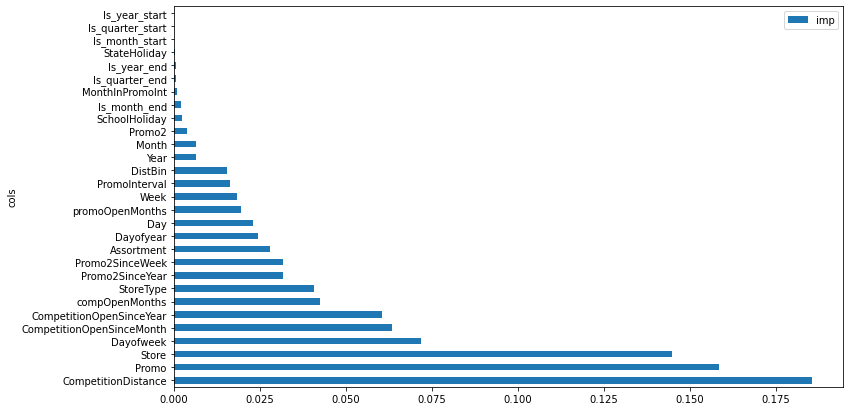

In [143]:
plot_fi(fi)

<b> Drop unimportant features

In [152]:
thresh = 5e-3
imp_features = fi['cols'][fi.imp>thresh]
xtrain_imp, xval_imp = xtrain[imp_features], xval[imp_features]

In [153]:
m_imp = rf(xtrain_imp, ytrain, n_estimators = 200, min_samples_leaf = 5, min_samples_split = 2)

In [154]:
m_rmspe_exp(m_imp, xtrain_imp, ytrain), m_rmspe_exp(m_imp, xval_imp, yval)

(0.12899419107664586, 0.13543707134771343)

<AxesSubplot:ylabel='cols'>

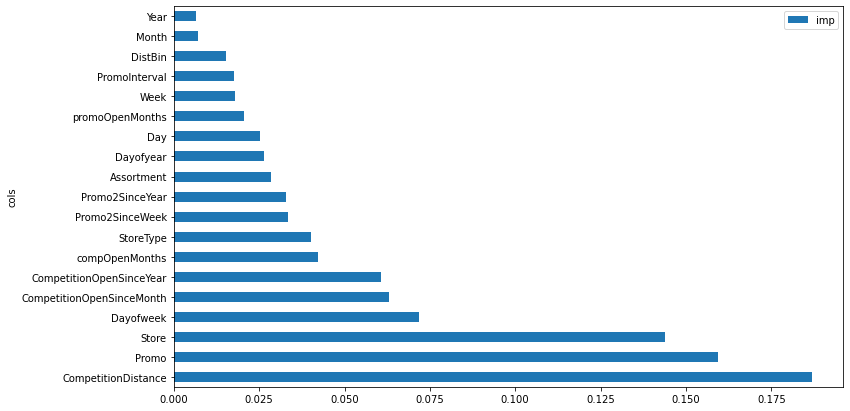

In [155]:
fi = rf_importance(m_imp, xtrain_imp)
plot_fi(fi)

<b> Feature Selection based on Column Similarity

In [134]:
# redundant features
def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

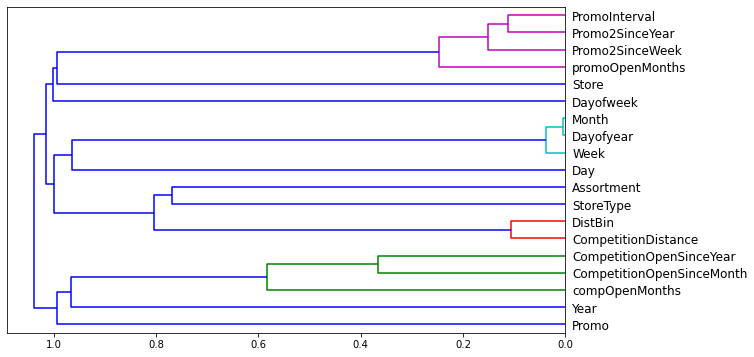

In [154]:
cluster_columns(xtrain_imp)

In [12]:
similar = [ 'DistBin', 'CompetitionDistance', 'Month', 'Dayofyear', 'Week', 'PromoInterval', 'Promo2SinceYear']

def get_oob(xs, ys):
    return rf(xs, ys).oob_score_

In [161]:
# trying to drop 
print(f'Original OOB: {get_oob(xtrain_imp, ytrain)}')
for d in similar:
    print(f'Dropping: {d}..OOB: {get_oob(xtrain_imp.drop(d, axis = 1), ytrain)}')

Original OOB: 0.8348378031312244
Dropping: DistBin..OOB: 0.830595747995524
Dropping: CompetitionDistance..OOB: 0.8076180879151601
Dropping: Month..OOB: 0.8390381018779096
Dropping: Dayofyear..OOB: 0.8352248391746255
Dropping: Week..OOB: 0.8382431709318144
Dropping: PromoInterval..OOB: 0.8358994070381136
Dropping: Promo2SinceYear..OOB: 0.8368182115376088


In [156]:
# dropping multiple - improved R squared
to_drop = ['Month', 'Dayofyear', 'Promo2SinceYear']
get_oob(xtrain_imp.drop(to_drop, axis = 1), ytrain)

0.834938364570296

In [157]:
xtrain_filt = xtrain_imp.drop(to_drop, axis = 1)
xval_filt = xval_imp.drop(to_drop, axis = 1)

In [158]:
m_filt = rf(xtrain_filt, ytrain, n_estimators = 300, min_samples_leaf = 5, min_samples_split = 2)

In [159]:
m_rmspe_exp(m_filt, xtrain_filt, ytrain), m_rmspe_exp(m_filt, xval_filt, yval)

(0.13014498138988292, 0.13512855428387074)

<AxesSubplot:ylabel='cols'>

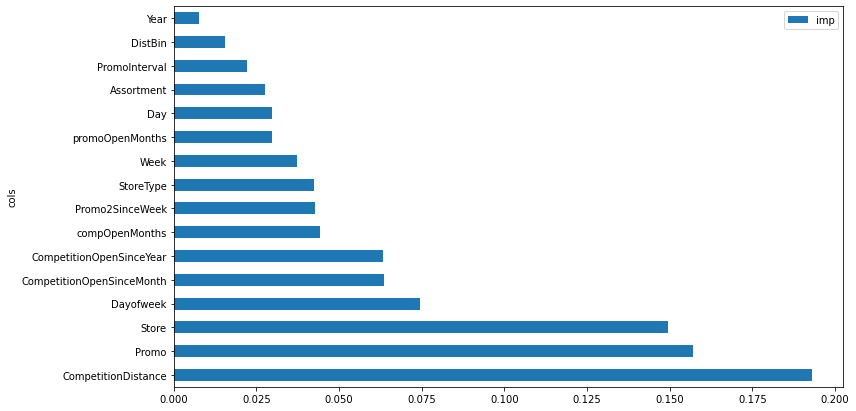

In [139]:
fi = rf_importance(m_filt, xtrain_filt)
plot_fi(fi)

In [160]:
# saving
(path/'rf-val.pkl').save(m_filt)
(path/'features-rf.pkl').save(list(xtrain_filt.columns))

################

In [175]:
# more feature deletion
similar = ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
           'compOpenMonths','promoOpenMonths', 'Promo2SinceWeek', 'DistBin', 'CompetitionDistance']

# trying to drop 
print(f'Original OOB: {get_oob(xtrain_filt, ytrain)}')
for d in similar:
    print(f'Dropping: {d}..OOB: {get_oob(xtrain_filt.drop(d, axis = 1), ytrain)}')

Original OOB: 0.8349436621415354
Dropping: CompetitionOpenSinceMonth..OOB: 0.820296865159206
Dropping: CompetitionOpenSinceYear..OOB: 0.8280620568523416
Dropping: compOpenMonths..OOB: 0.8277718721194516
Dropping: promoOpenMonths..OOB: 0.8277722611878949
Dropping: Promo2SinceWeek..OOB: 0.8240184836045776
Dropping: DistBin..OOB: 0.827475099363181
Dropping: CompetitionDistance..OOB: 0.7950467485956972


In [176]:
to_drop2 = ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'DistBin']
get_oob(xtrain_filt.drop(to_drop2, axis = 1), ytrain)

0.7936886658488875

Score got worse so let's keep them

<b> Partial Dependence Plots

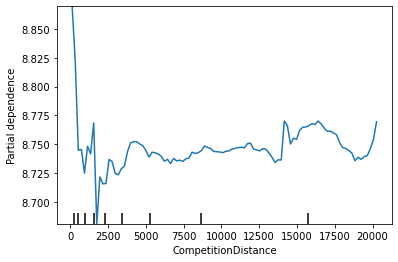

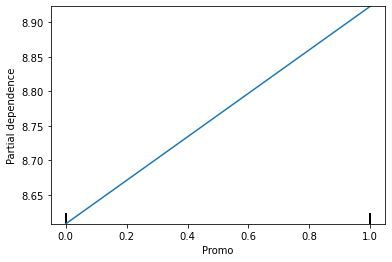

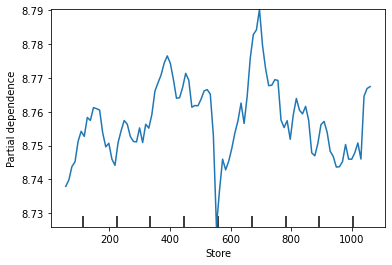

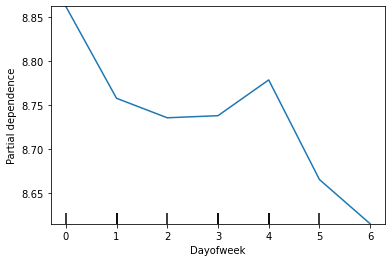

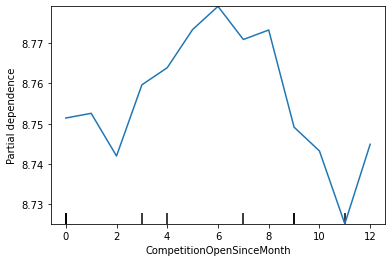

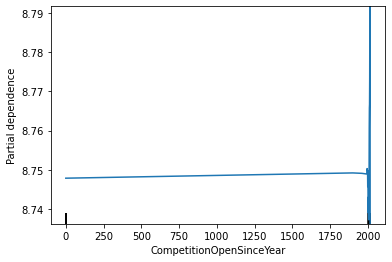

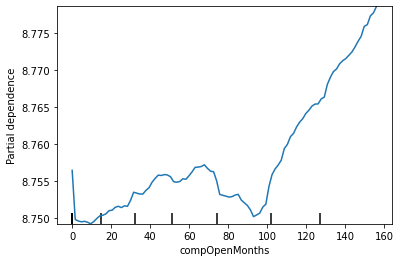

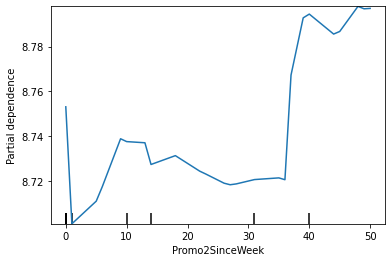

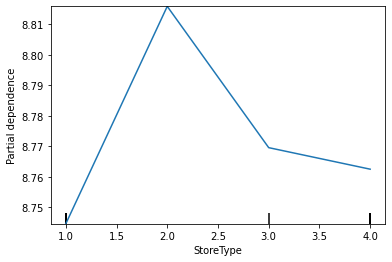

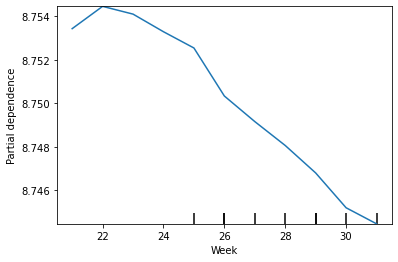

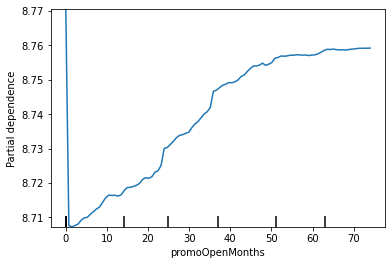

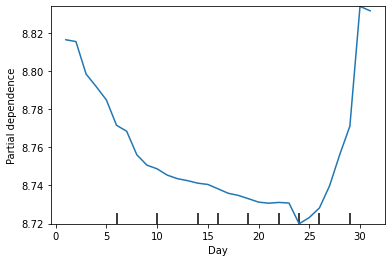

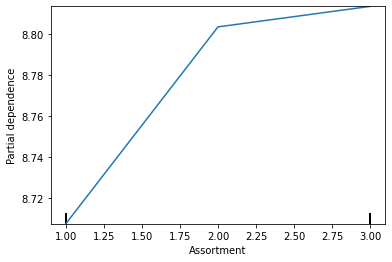

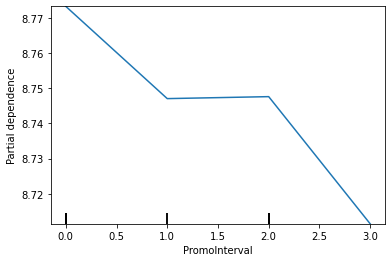

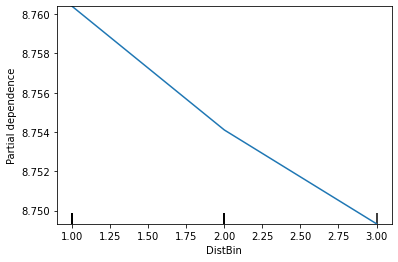

C:\Users\Arpan\Anaconda3\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:582: UserWarning: Attempting to set identical bottom == top == 8.770142577549464 results in singular transformations; automatically expanding.
  axi.set_ylim(self.pdp_lim[1])


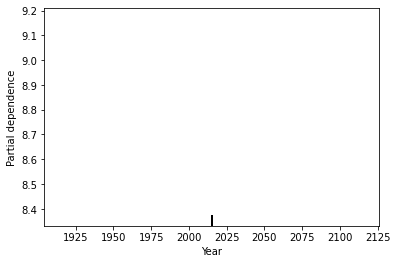

In [183]:
for f in fi.cols:
    plot_partial_dependence(m_filt, xval_filt, [f])
    plt.show()

In [215]:
trainval.groupby('Promo2').agg({'Sales':['mean','std']})

Sales             
               mean          std
Promo2                          
0       7350.818414  3394.049065
1       6558.993542  2724.593057

Promoint's pdp suggests that the sales are highes for stores which do not participate in promo2 (highest at 0) <br>
This is reaffirmed by the mean sales grouped by Promo2

<b> Predictions

In [141]:
# get predictions
def get_preds(m, xs, features, exp = False):
    ids = xs['Id']
    x = xs.drop('Id', axis = 1)
    x = x[features]    
    preds = m.predict(x)
    if exp:
        preds = np.exp(preds)
    
    return pd.DataFrame(data = {'Id':ids, 'Sales':preds}).sort_values('Id').reset_index(drop = True)

In [142]:
features = xtrain_filt.columns

In [143]:
m_all = rf(xtrain_filt.append(xval_filt), ytrain.append(yval), 
           n_estimators = 300, min_samples_leaf = 5, min_samples_split = 2)

In [144]:
(path/'rf-all.pkl').save(m_all)

In [200]:
predictions = get_preds(m_all, test, features, exp = True)
predictions

Id         Sales
0          1   4580.891655
1          2   7823.750084
2          3   9329.253562
3          4   7036.626147
4          5   7550.675285
...      ...           ...
41083  41084   2990.262156
41084  41085   7526.469032
41085  41086   6067.956289
41086  41087  21707.912777
41087  41088   7238.667450

[41088 rows x 2 columns]

In [201]:
predictions.to_csv('rf-sub.csv', index = False) #0.12177

## XGBOOST

In [14]:
def xgb(xs, ys, objective = 'reg:squarederror', n_estimators = 200, max_depth = 3, learning_rate = 0.001, 
        booster = 'gbtree', colsample_bytree = 0.5, **kwargs):
    return xgboost.XGBRegressor(objective = objective, 
                         n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate,
                        booster = booster, colsample_bytree = colsample_bytree, n_jobs = -1).fit(xs, ys)

In [31]:
# convert categories to int
categories = [c for c in xtrain.columns if xtrain[c].dtypes!=np.float64]
xtrain_xgb, xval_xgb = xtrain.copy(), xval.copy()
xtrain_xgb[categories] = xtrain_xgb[categories].astype(np.int64)
xval_xgb[categories] = xval_xgb[categories].astype(np.int64)

In [252]:
mxgb = xgb(xtrain_xgb, ytrain, n_estimators = 300, max_depth = 10, learning_rate = 0.1)

In [253]:
m_rmspe_exp(mxgb, xtrain_xgb, ytrain), m_rmspe_exp(mxgb, xval_xgb, yval)

(0.0949529443935043, 0.12748615526321716)

In [256]:
mxgb = xgb(xtrain_xgb, ytrain, n_estimators = 300, max_depth = 10, learning_rate = 0.1, subsample = 0.4)

In [257]:
m_rmspe_exp(mxgb, xtrain_xgb, ytrain), m_rmspe_exp(mxgb, xval_xgb, yval)

(0.0949529443935043, 0.12748615526321716)

In [258]:
mxgb = xgb(xtrain_xgb, ytrain, n_estimators = 500, max_depth = 10, learning_rate = 0.1, subsample = 0.4)

In [259]:
m_rmspe_exp(mxgb, xtrain_xgb, ytrain), m_rmspe_exp(mxgb, xval_xgb, yval)

(0.0833539301790422, 0.12412491258333541)

In [262]:
mxgb = xgb(xtrain_xgb, ytrain, n_estimators = 500, max_depth = 8, learning_rate = 0.1, subsample = 0.4)

In [263]:
m_rmspe_exp(mxgb, xtrain_xgb, ytrain), m_rmspe_exp(mxgb, xval_xgb, yval)

(0.10502749213106037, 0.1289008026276894)

In [33]:
mxgb = xgb(xtrain_xgb, ytrain, n_estimators = 500, max_depth = 10, learning_rate = 0.08, subsample = 0.4, reg_lambda = 0.01)

In [34]:
m_rmspe_exp(mxgb, xtrain_xgb, ytrain), m_rmspe_exp(mxgb, xval_xgb, yval)

(0.0882100010391496, 0.1227059074292185)

<b> Feature Importance

In [15]:
def xgb_importance(m,  df):
    return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending = False)

In [35]:
fixgb = xgb_importance(mxgb, xtrain_xgb)
fixgb

cols       imp
2                       Promo  0.229317
7         CompetitionDistance  0.081598
12            Promo2SinceYear  0.078141
0                       Store  0.064825
5                   StoreType  0.063175
6                  Assortment  0.061051
8   CompetitionOpenSinceMonth  0.052248
9    CompetitionOpenSinceYear  0.050589
10                     Promo2  0.043701
13              PromoInterval  0.042174
28                    DistBin  0.041014
17                  Dayofweek  0.030916
11            Promo2SinceWeek  0.030059
23                Is_year_end  0.025122
3                StateHoliday  0.012453
26             compOpenMonths  0.011961
18                  Dayofyear  0.010373
1                        Week  0.009877
16                        Day  0.009047
27            promoOpenMonths  0.008998
21             Is_quarter_end  0.007464
14                       Year  0.007409
19               Is_month_end  0.006519
15                      Month  0.005774
4               SchoolHoliday  0.005727
24              Is_year_start  0.004280
22           Is_quarter_start  0.002421
25            MonthInPromoInt  0.001951
20             Is_month_start  0.001817

In [36]:
thresh = 0.007
features_imp = fixgb.cols[fixgb.imp > thresh]
xtrain_xgb_imp, xval_xgb_imp = xtrain_xgb[features_imp], xval_xgb[features_imp]

In [278]:
mxgb_imp = xgb(xtrain_xgb_imp, ytrain, n_estimators = 500, max_depth = 10, learning_rate = 0.08, subsample = 0.4, reg_lambda = 0.01)

In [279]:
m_rmspe_exp(mxgb_imp, xtrain_xgb_imp, ytrain), m_rmspe_exp(mxgb_imp, xval_xgb_imp, yval)

(0.08953070108667278, 0.12336975254941208)

In [284]:
mxgb_imp = xgb(xtrain_xgb_imp, ytrain, n_estimators = 600, max_depth = 10, learning_rate = 0.08, subsample = 0.5, reg_lambda = 0.02)

In [285]:
m_rmspe_exp(mxgb_imp, xtrain_xgb_imp, ytrain), m_rmspe_exp(mxgb_imp, xval_xgb_imp, yval)

(0.085409895666388, 0.12185030852675743)

<b> Dropping features - based on rf oob score

In [37]:
to_drop = ['Dayofyear', 'Promo2SinceYear']
xtrain_xgb_filt, xval_xgb_filt = xtrain_xgb_imp.drop(to_drop, axis = 1), xval_xgb_imp.drop(to_drop, axis = 1)

In [289]:
mxgb_filt = xgb(xtrain_xgb_filt, ytrain, n_estimators = 600, max_depth = 10, learning_rate = 0.08, subsample = 0.5, reg_lambda = 0.02)

In [290]:
m_rmspe_exp(mxgb_filt, xtrain_xgb_filt, ytrain), m_rmspe_exp(mxgb_filt, xval_xgb_filt, yval)

(0.08666830243614607, 0.12241831894478647)

In [38]:
mxgb_filt = xgb(xtrain_xgb_filt, ytrain, n_estimators = 800, max_depth = 10, learning_rate = 0.06, subsample = 0.5, reg_lambda = 0.02)

In [39]:
m_rmspe_exp(mxgb_filt, xtrain_xgb_filt, ytrain), m_rmspe_exp(mxgb_filt, xval_xgb_filt, yval)

(0.08746014543255834, 0.12110308957437994)

In [40]:
# saving model
(path/'xgb-val.pkl').save(mxgb_filt)
(path/'feature-xgb.pkl').save(list(xtrain_xgb_filt.columns))

############

In [296]:
mxgb_filt = xgb(xtrain_xgb_filt, ytrain, n_estimators = 800, max_depth = 12, learning_rate = 0.03, subsample = 0.6, reg_lambda = 0.02)

In [297]:
m_rmspe_exp(mxgb_filt, xtrain_xgb_filt, ytrain), m_rmspe_exp(mxgb_filt, xval_xgb_filt, yval)

(0.08452684145961607, 0.12184889558613156)

<b> Predictions

In [299]:
featuresxgb = xtrain_xgb_filt.columns

In [41]:
m_all_xgb = xgb(xtrain_xgb_filt.append(xval_xgb_filt), ytrain.append(yval), n_estimators = 800, max_depth = 10, learning_rate = 0.06, subsample = 0.5, reg_lambda = 0.02)

In [42]:
(path/'xgb-full.pkl').save(m_all_xgb)

In [301]:
testxgb = test.copy()
testxgb[categories] = testxgb[categories].astype(np.int64)

In [303]:
predictions = get_preds(m_all_xgb, testxgb, featuresxgb, exp = True)
predictions

Id         Sales
0          1   4112.878418
1          2   7473.230469
2          3   9113.497070
3          4   6848.874023
4          5   6831.229004
...      ...           ...
41083  41084   2637.848633
41084  41085   7781.312500
41085  41086   6486.937988
41086  41087  23832.169922
41087  41088   7567.793457

[41088 rows x 2 columns]

In [304]:
predictions.to_csv('xgb-preds.csv', index = False) # 0.11213

## Neural Networks

In [69]:
# cont cat splits
d = ['Sales', 'Date']
cont, cat = cont_cat_split(trainval.drop(d, axis = 1), dep_var = 'LogSales', max_card = 9000)

In [70]:
# convert to Tabular Pandas
procs = [Categorify, Normalize]
to = TabularPandas(trainval.drop(d, axis = 1), y_names = 'LogSales', cont_names=cont, cat_names = cat, procs = procs, splits=splits)

In [323]:
# train
to.train.items.head()

Store  Week  Promo  StateHoliday  SchoolHoliday  StoreType  Assortment  \
42      1    24      1             1              1          3           1   
43      1    24      1             1              1          3           1   
44      1    24      1             1              1          3           1   
45      1    24      1             1              1          3           1   
46      1    24      1             1              1          3           1   

    CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  \
42            -0.534959                         10                        17   
43            -0.534959                         10                        17   
44            -0.534959                         10                        17   
45            -0.534959                         10                        17   
46            -0.534959                         10                        17   

    Promo2  Promo2SinceWeek  Promo2SinceYear  PromoInterval  LogSales  Year  \
42       1                1                1              1  8.214736     3   
43       1                1                1              1  8.196161     3   
44       1                1                1              1  8.186186     3   
45       1                1                1              1  8.319230     3   
46       1                1                1              1  8.311644     3   

    Month  Day  Dayofweek  Dayofyear  Is_month_end  Is_month_start  \
42      6   12          5        163             1               1   
43      6   11          4        162             1               1   
44      6   10          3        161             1               1   
45      6    9          2        160             1               1   
46      6    8          1        159             1               1   

    Is_quarter_end  Is_quarter_start  Is_year_end  Is_year_start  \
42               1                 1            1              1   
43               1                 1            1              1   
44               1                 1            1              1   
45               1                 1            1              1   
46               1                 1            1              1   

    MonthInPromoInt  compOpenMonths  promoOpenMonths  DistBin  
42                1        0.750491        -0.698698        1  
43                1        0.750491        -0.698698        1  
44                1        0.750491        -0.698698        1  
45                1        0.750491        -0.698698        1  
46                1        0.750491        -0.698698        1

In [324]:
# valid
to.valid.items.head()

Store  Week  Promo  StateHoliday  SchoolHoliday  StoreType  Assortment  \
41      1    24      1             1              1          3           1   
40      1    25      2             1              1          3           1   
39      1    25      2             1              1          3           1   
38      1    25      2             1              1          3           1   
37      1    25      2             1              1          3           1   

    CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  \
41            -0.534959                         10                        17   
40            -0.534959                         10                        17   
39            -0.534959                         10                        17   
38            -0.534959                         10                        17   
37            -0.534959                         10                        17   

    Promo2  Promo2SinceWeek  Promo2SinceYear  PromoInterval  LogSales  Year  \
41       1                1                1              1  8.356085     3   
40       1                1                1              1  8.615770     3   
39       1                1                1              1  8.487146     3   
38       1                1                1              1  8.294049     3   
37       1                1                1              1  8.443546     3   

    Month  Day  Dayofweek  Dayofyear  Is_month_end  Is_month_start  \
41      6   13          6        164             1               1   
40      6   15          1        166             1               1   
39      6   16          2        167             1               1   
38      6   17          3        168             1               1   
37      6   18          4        169             1               1   

    Is_quarter_end  Is_quarter_start  Is_year_end  Is_year_start  \
41               1                 1            1              1   
40               1                 1            1              1   
39               1                 1            1              1   
38               1                 1            1              1   
37               1                 1            1              1   

    MonthInPromoInt  compOpenMonths  promoOpenMonths  DistBin  
41                1        0.750491        -0.698698        1  
40                1        0.750491        -0.698698        1  
39                1        0.750491        -0.698698        1  
38                1        0.750491        -0.698698        1  
37                1        0.750491        -0.698698        1

In [18]:
# metrics
def nn_rmspe_exp(preds,targs):return rmspe(np.exp(targs.cpu().detach().numpy()), np.exp(preds.cpu().detach().numpy()))

In [328]:
# determining y range values
to.train.y.min(), to.train.y.max()

(3.828641414642334, 10.564163208007812)

In [19]:
# dataloader and learn object
def get_learner(to, bs, layers = [500, 250], **kwargs):    
    dls = to.dataloaders(bs)
    return  tabular_learner(dls, layers = layers, 
                            loss_func = F.mse_loss, 
                            metrics = [nn_rmspe_exp], n_out = 1,
                            y_range = (3., 11.))

In [334]:
learn = get_learner(to, 1024)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0005754399462603033)

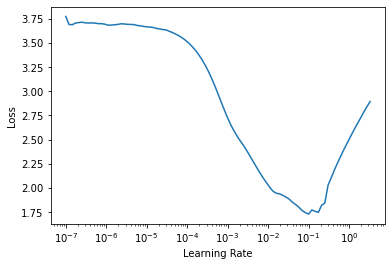

In [335]:
learn.lr_find()

In [336]:
learn.fit_one_cycle(6, 8e-3)

In [340]:
learn = get_learner(to, 1024, config = tabular_config(embed_p = 0.2))

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.0008317637839354575)

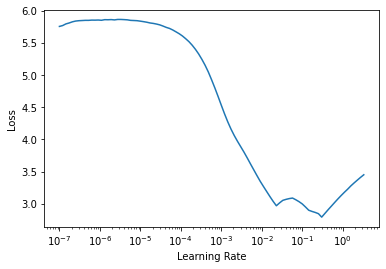

In [341]:
learn.lr_find()

In [342]:
learn.fit_one_cycle(10, 1e-2)

In [343]:
# wd
learn = get_learner(to, 1024)

In [344]:
learn.fit_one_cycle(10, 8e-3, wd = 0.03)

In [350]:
# wd
learn = get_learner(to, 1024, layers = [600, 300])

In [351]:
learn.fit_one_cycle(14, 1e-2, wd = 0.06)

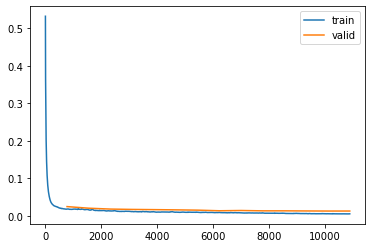

In [355]:
learn.recorder.plot_loss()

In [356]:
# save
learn.save('nn-600-300-wd06')

Path('models/nn-600-300-wd06.pth')

In [409]:
learn = get_learner(to, 1024, layers = [600, 300], config = tabular_config(embed_p = 0.2), wd = 0.03)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0004786300996784121)

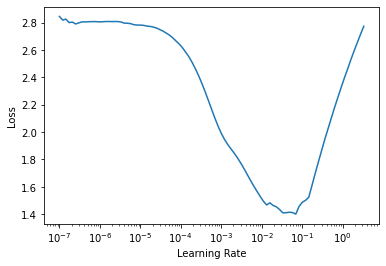

In [410]:
learn.lr_find()

In [411]:
learn.fit_one_cycle(10, 8e-3)

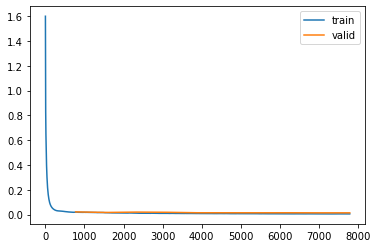

In [412]:
learn.recorder.plot_loss()

<b> Predictions

In [413]:
# training on full dataset
procs = [Categorify, Normalize]
to_full = TabularPandas(trainval.drop(d, axis = 1), y_names = 'LogSales', cont_names=cont, cat_names = cat, procs = procs)

In [499]:
learn = get_learner(to_full, 1024, layers = [600, 300],  config = tabular_config(embed_p = 0.2), wd = 0.03)

In [415]:
learn.fit_one_cycle(10, 8e-3)

C:\Users\Arpan\Anaconda3\lib\site-packages\fastprogress\fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [416]:
# # save
# learn.save('nn_full_600-300-wd06')

Path('models/nn_full_600-300-wd06.pth')

In [516]:
learn.load('nn_full_600-300-wd06')

In [577]:
learn.dls.test_dl??

In [583]:
# getting predictions
#testdl = learn.dls.test_dl(test, bs = 1024, shuffle = False)
preds = [torch.exp(learn.predict(test.iloc[i])[1]).item() for i in range(len(test))]

In [584]:
prediction = pd.DataFrame({'Id': test.Id, 'Sales': preds}).sort_values('Id').reset_index(drop = True)
prediction # 0.112

Id         Sales
0          1   4344.852539
1          2   7798.502930
2          3   9321.622070
3          4   8691.259766
4          5   8640.227539
...      ...           ...
41083  41084   3350.622314
41084  41085   8009.229980
41085  41086   6643.736328
41086  41087  24444.541016
41087  41088   7638.999512

[41088 rows x 2 columns]

<AxesSubplot:>

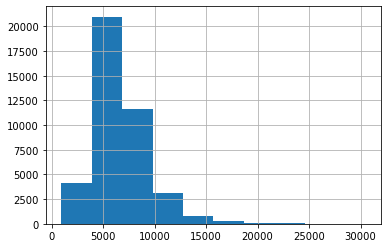

In [585]:
prediction.Sales.hist()

In [586]:
prediction.to_csv('nn-ee.csv', index = False)

## Random Forest with EE

<b> Training Embeddings

In [39]:
embszs = {}
for c in to.classes.keys():
    n = trainval[c].nunique()
    if n>=10:
        s = 10
    else:
        s = n
    embszs[c] = s

In [22]:
dls = to.dataloaders(1024)
learn = tabular_learner(dls, layers = [500, 300], n_out = 1, 
                        loss_func = F.mse_loss, metrics = [nn_rmspe_exp], emb_szs = embszs)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0020892962347716093)

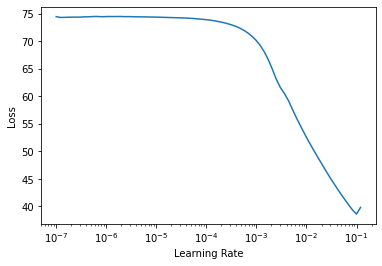

In [23]:
learn.lr_find()

In [24]:
learn.fit_one_cycle(10, 1e-2)

In [25]:
# saving embeddings
(path/'cat-embeddings.pkl').save(learn.model.embeds)

<b>Using embeddings in RF

In [71]:
# emb = (path/'cat-embeddings.pkl').load()
learn = get_learner(to, 1024, layers = [600, 300])
learn.load('nn-600-300-wd06')
emb = learn.model.embeds

In [164]:
# # get embeddings of categories
# embeds = [e(torch.LongTensor(np.array(to.items[cat].iloc[:,i]).astype(np.float64))).detach().cpu().numpy() for i,e in enumerate(emb.to('cpu'))]

In [72]:
train_embeds = [e(torch.LongTensor(np.array(to.train.items[cat].iloc[:,i]).astype(np.float64))).detach().cpu().numpy() for i,e in enumerate(emb.to('cpu'))]
val_embed = [e(torch.LongTensor(np.array(to.valid.items[cat].iloc[:,i]).astype(np.float64))).detach().cpu().numpy() for i,e in enumerate(emb.to('cpu'))]

In [73]:
train_cont_array = to.train.items[cont].values.astype(float)
train_embed = np.hstack(train_embeds)

valid_cont_array = to.valid.items[cont].values.astype(float)
valid_embed = np.hstack(val_embed)

In [75]:
#splitting
trainx, validx = np.hstack([train_cont_array, train_embed]), np.hstack([valid_cont_array, valid_embed])
y, validy = to.train.y, to.valid.y

In [76]:
trainx.shape, y.shape, validx.shape, validy.shape

((797508, 249), (797508,), (46830, 249), (46830,))

In [91]:
embszs = [s for _,s in get_emb_sz(to)]

In [109]:
cols = []
cols.extend(cont)
for idx in range(len(cat)):
    ct_cols = [f'{cat[idx]}_{i}' for i in range(embszs[idx])]
    cols.extend(ct_cols)

In [110]:
train_df = pd.DataFrame(trainx, columns = cols)
valid_df = pd.DataFrame(validx, columns = cols)

In [113]:
m_ee = rf(train_df, y, n_estimators = 300, min_samples_split = 2, min_samples_leaf = 5)

In [114]:
m_rmspe_exp(m_ee, train_df, y), m_rmspe_exp(m_ee, valid_df, validy)

(0.10133156351859238, 0.13897454179120677)

<b> Feature Importance

In [122]:
fiee = rf_importance(m_ee, train_df)
fiee.head(100)

cols       imp
17   Store_14  0.138488
32   Store_29  0.061998
100   Promo_1  0.061187
101   Promo_2  0.054935
99    Promo_0  0.052242
..        ...       ...
42   Store_39  0.001322
52   Store_49  0.001270
166     Day_1  0.001269
12    Store_9  0.001268
51   Store_48  0.001267

[100 rows x 2 columns]

In [123]:
# thresh
thresh = 0.001
f = fiee.cols[fiee.imp>=thresh]
trainx_imp = train_df[f]
validx_imp = valid_df[f]

In [124]:
m_ee_imp =  rf(trainx_imp, y, n_estimators = 300, min_samples_split = 2, min_samples_leaf = 5)

In [125]:
m_rmspe_exp(m_ee_imp, trainx_imp, y), m_rmspe_exp(m_ee_imp, validx_imp, validy)

(0.10190560295383042, 0.13781375777204566)